In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt

import numpy as np
from scipy.io.wavfile import write

import tensorflow as tf

from pydub import AudioSegment
import audiosegment
from pydub.silence import split_on_silence
import sounddevice as sd

In [28]:
SAMPLE_RATE = 16000
SECONDS = 12  # Duration
FRAME_SIZE=30

## Start the recording

In [ ]:
recording = sd.rec(int(SECONDS * SAMPLE_RATE), samplerate=SAMPLE_RATE, channels=1)
sd.wait()  
write('live_record/output.wav', SAMPLE_RATE, recording)

## Edit recording and split to parts

In [33]:
#Normalize a chunk to a target dbfs.
def match_target_dbfs(chunk, target_dbfs):
    dbfs = target_dbfs - chunk.dBFS
    return chunk.apply_gain(dbfs)

recording=audiosegment.from_file("live_record/output.wav")

chunks = split_on_silence(
    # Use loaded audio.
    recording, 
    # Specify that a silent chunk must be at least 0.2 seconds or 200 ms long.
    min_silence_len = 200,
    # Consider a chunk silent if it's quieter than -38 dBFS.
    silence_thresh = -38
)

# Process each chunk from the recorded audio and export
for i, chunk in enumerate(chunks):
    # Apply filters to the chunk
    audio_chunk = (chunk.high_pass_filter(3000)).low_pass_filter(100)
    #Normalize the given chunk
    normalized_chunk = match_target_dbfs(audio_chunk, -15.0)
    #Set custom sample rate
    normalized_chunk = normalized_chunk.set_frame_rate(SAMPLE_RATE)
    
    # Export the audio chunk with new parameters so that they fit with the dataset audio settings.
    print("Exporting chunk{0}.wav".format(i))
    normalized_chunk.export(
        "chunk{0}.wav".format(i),
        format = "wav",
        codec="pcm_s16le",
        bitrate = "128k"
    )

Exporting chunk0.wav
Exporting chunk1.wav
Exporting chunk2.wav
Exporting chunk3.wav
Exporting chunk4.wav
Exporting chunk5.wav
Exporting chunk6.wav
Exporting chunk7.wav
Exporting chunk8.wav
Exporting chunk9.wav


## Load trained model

In [31]:
model = tf.keras.models.load_model("save/model.h5")

## Function to evaluate the audio

In [50]:
def audio_evaluation(FILE_PATH):
 #Get raw .wav data and sampling rate from librosa's load function
    raw_w, sampling_rate = librosa.load(FILE_PATH, mono=True)

    
    #Obtain MFCC Features from raw data
    mfcc_features = librosa.feature.mfcc(raw_w, sampling_rate)
    #Cut or pad
    if mfcc_features.shape[1] > FRAME_SIZE:
        mfcc_features = mfcc_features[:, :FRAME_SIZE]
    else:
        mfcc_features = np.pad(mfcc_features, 
                               ((0, 0), (0, FRAME_SIZE - mfcc_features.shape[1])),
                               mode='constant', 
                               constant_values=0)

    #Extract MFCC features from single file path given sample length
    mfcc_features = mfcc_features.flatten()

    #mfcc_features: 1D numpy array, shape: (1, # of mfcc features, )
    # Reshape the mfcc_features to meet the requirements
    mfcc_features = mfcc_features.reshape((1, -1))
    #Predict the label
    pred_label = np.argmax(model.predict(mfcc_features))
    
    return pred_label,raw_w

## Predict the result

In [54]:
result="\nYou said: "
for i in range(10):
    
    FILE_PATH = "chunk{0}.wav".format(i)
    prediction,raw_w=audio_evaluation(FILE_PATH)
    result=result+'{} '.format(prediction)

print(result)


You said: 0 1 2 3 4 5 6 7 8 9 


## Visualize the audio chunks

File loaded: chunk0.wav
Predicted label: 0 


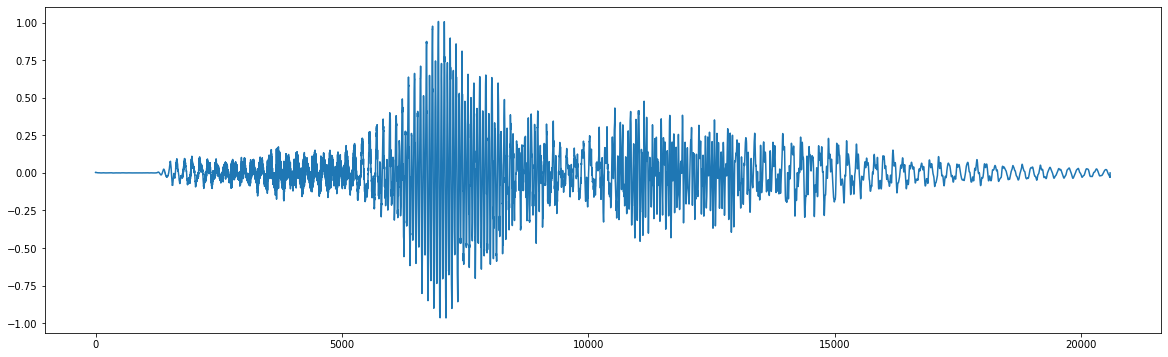

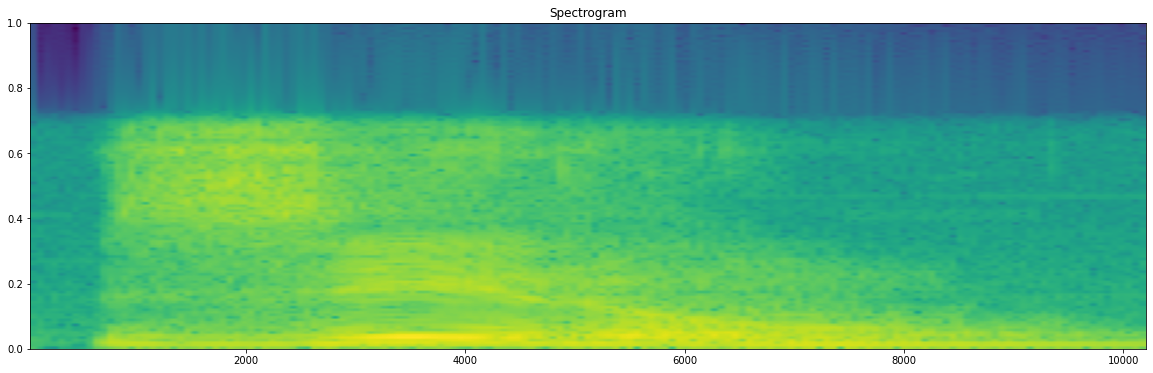

File loaded: chunk1.wav
Predicted label: 1 


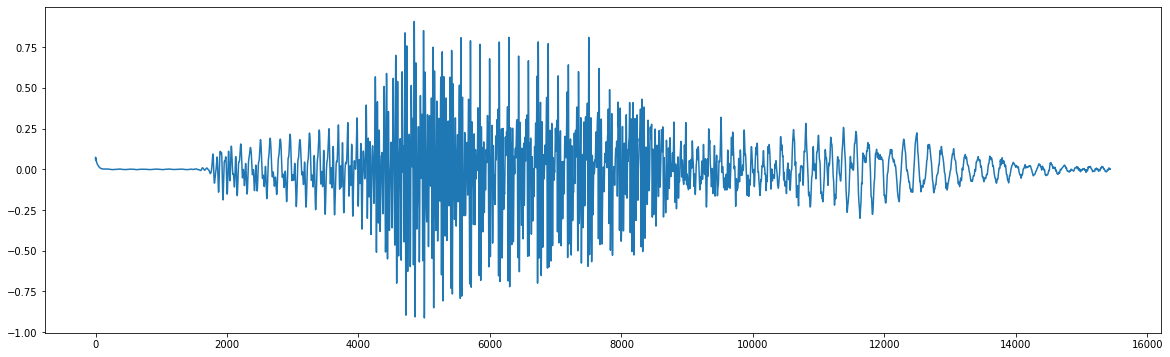

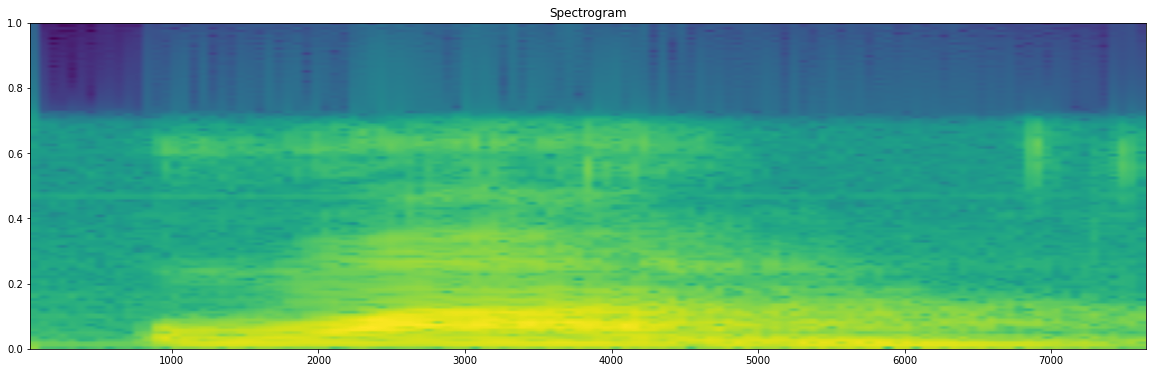

File loaded: chunk2.wav
Predicted label: 2 


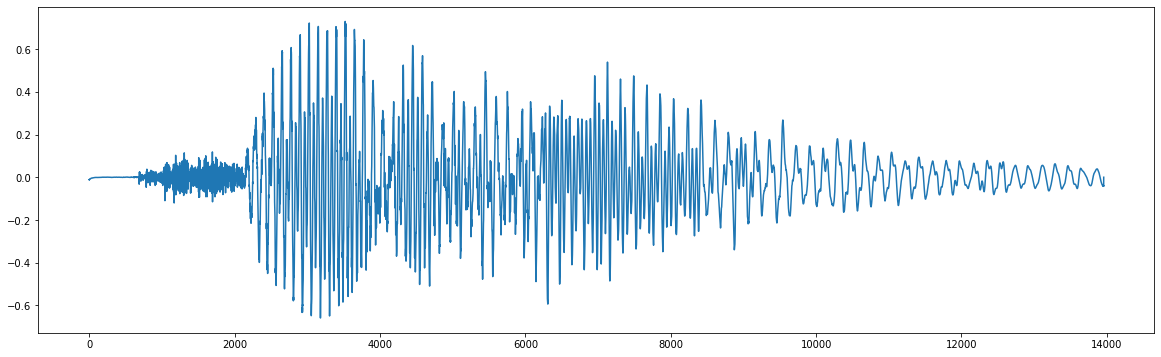

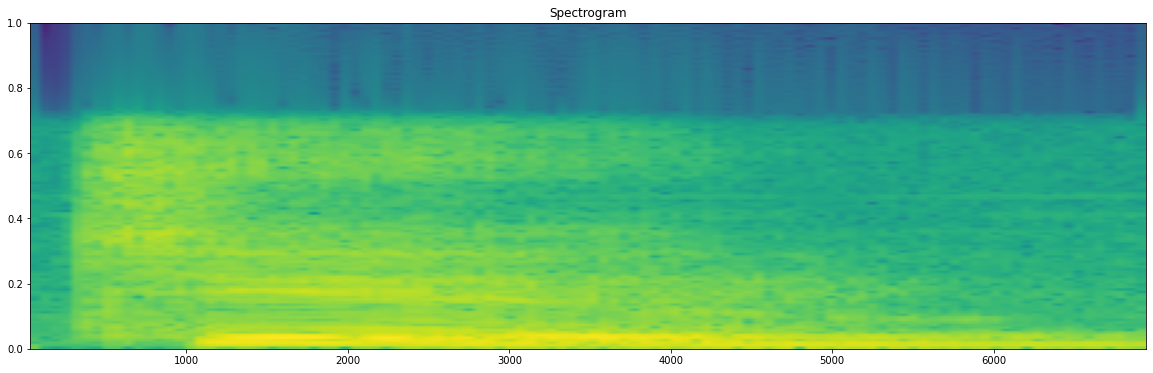

File loaded: chunk3.wav
Predicted label: 3 


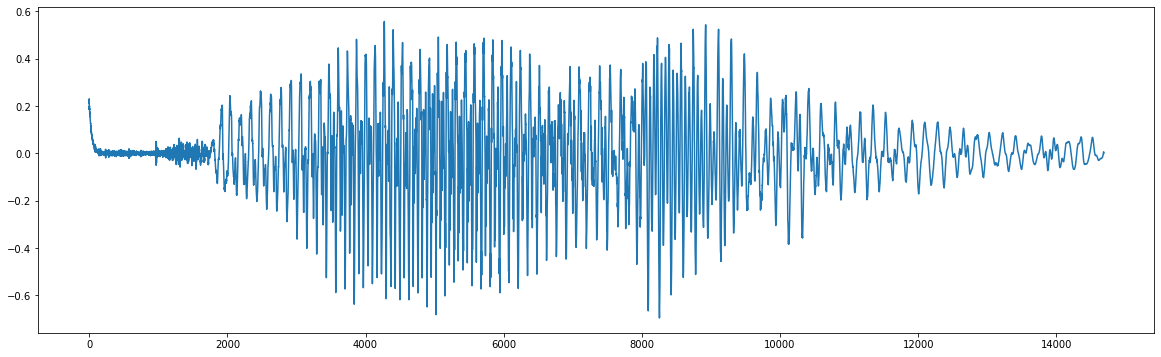

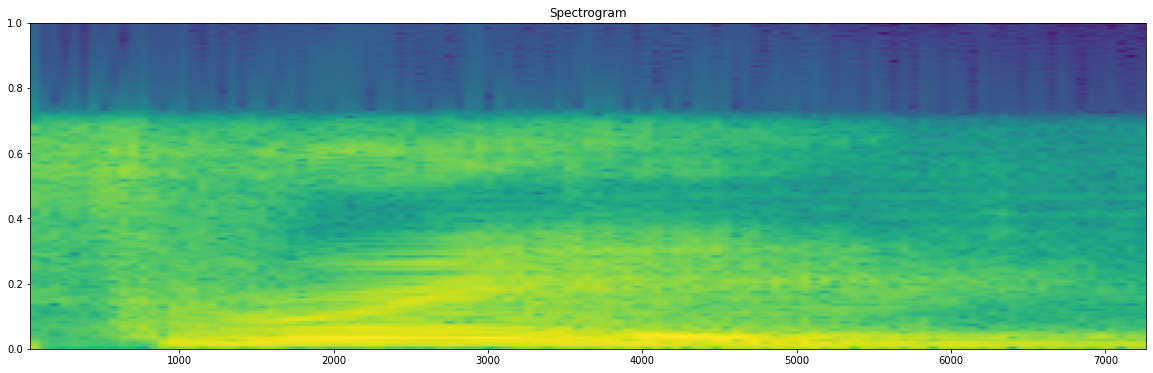

File loaded: chunk4.wav
Predicted label: 4 


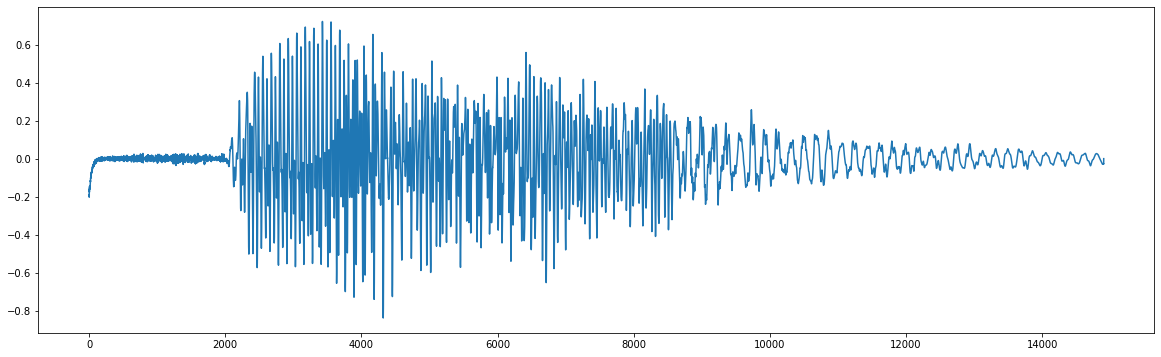

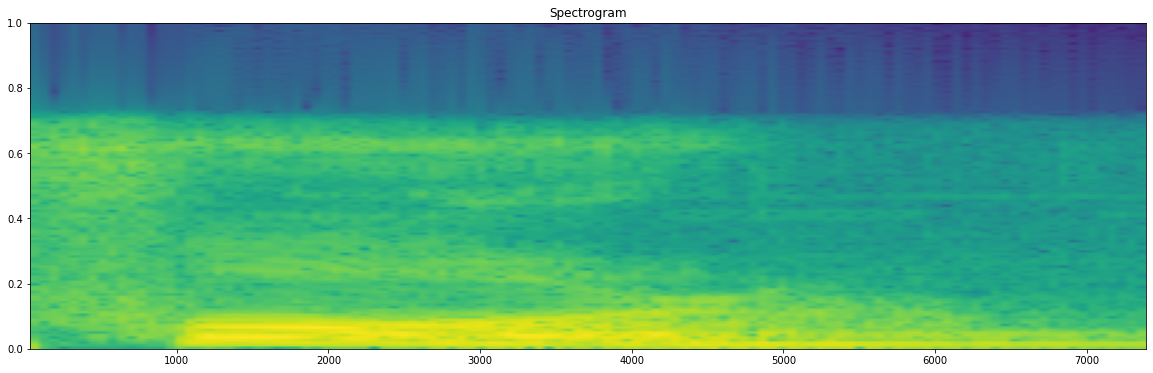

File loaded: chunk5.wav
Predicted label: 5 


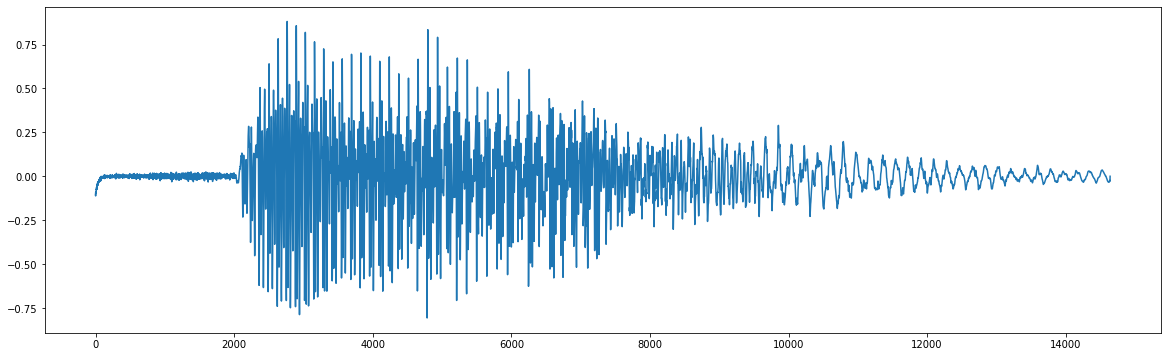

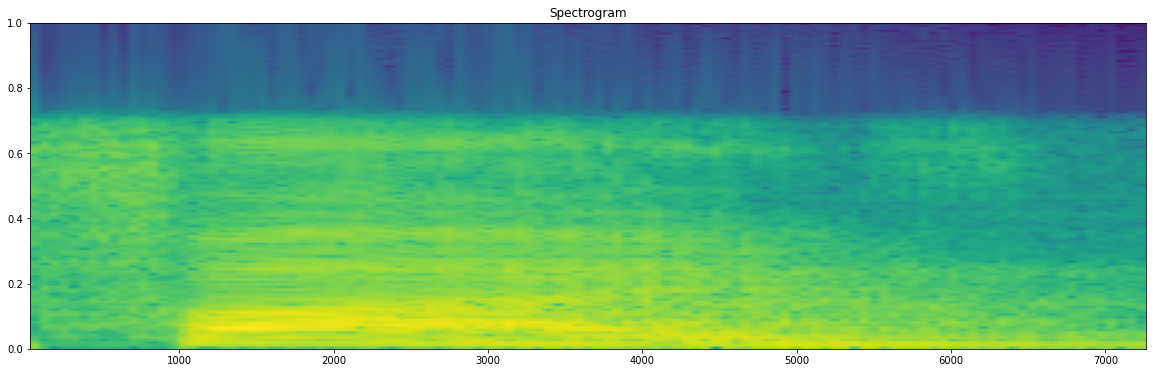

File loaded: chunk6.wav
Predicted label: 6 


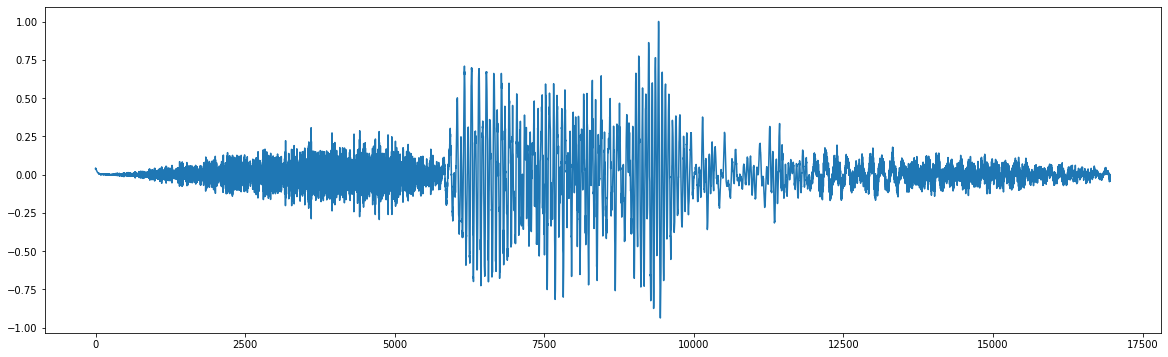

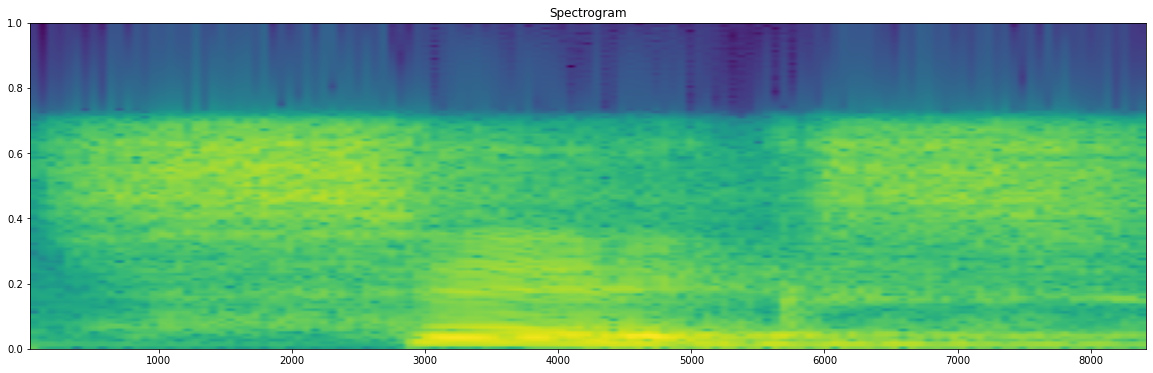

File loaded: chunk7.wav
Predicted label: 7 


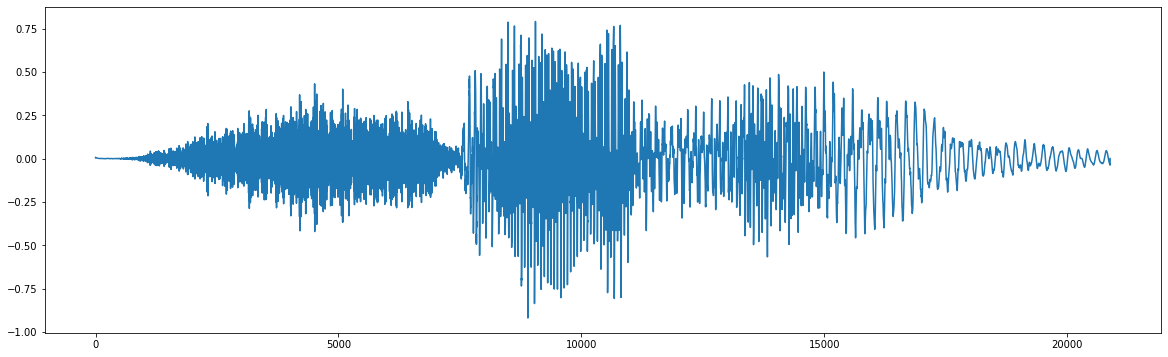

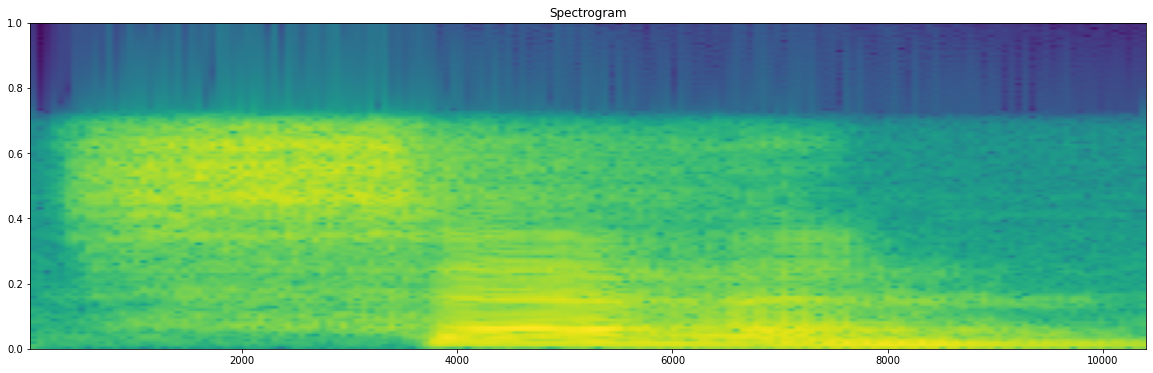

File loaded: chunk8.wav
Predicted label: 8 


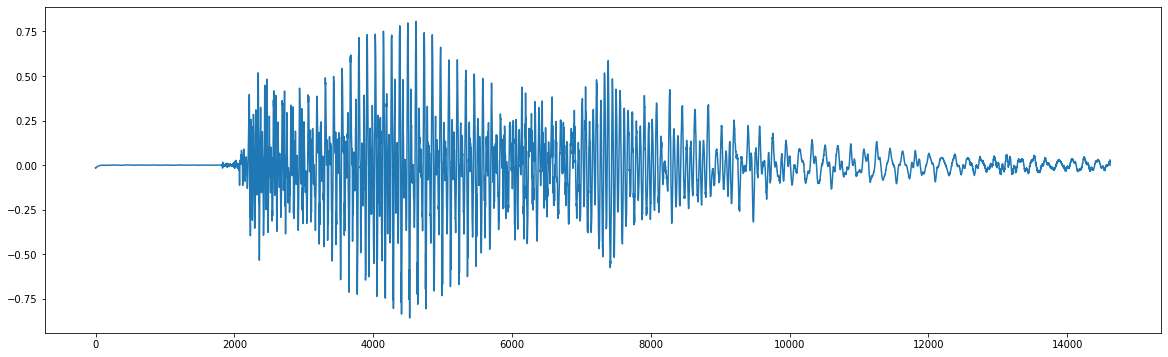

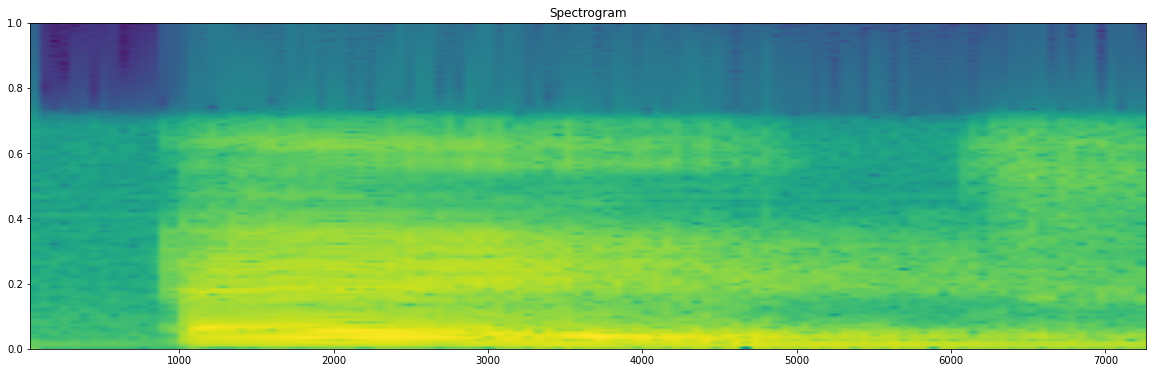

File loaded: chunk9.wav
Predicted label: 9 


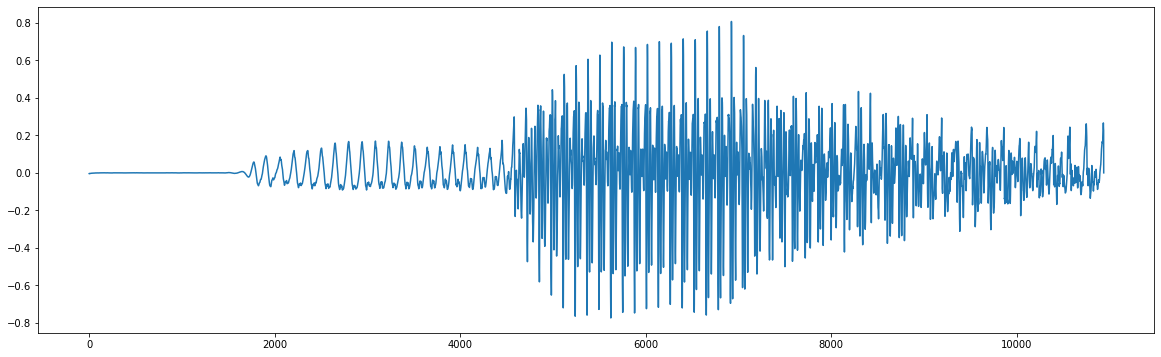

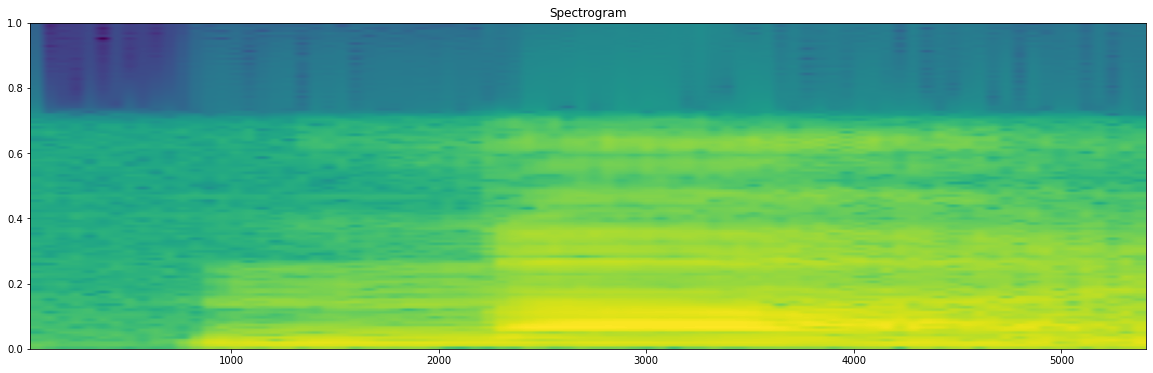

In [53]:
for i in range(10):
    
    FILE_PATH = "chunk{0}.wav".format(i)

    prediction,raw_w=audio_evaluation(FILE_PATH)
    print('File loaded: {}'.format(FILE_PATH))
    print('Predicted label: {} '.format(prediction))
    fig, ax = plt.subplots(1, figsize=(20, 6))
    plt.plot(raw_w)
    fig, ax = plt.subplots(1, figsize=(20, 6))
    plt.specgram(raw_w)
    plt.title('Spectrogram')
    plt.show()